In [22]:
import numpy as np
import pandas as pd
import os
from glob import glob
import laspy
import cv2

In [ ]:
https://github.com/tahirdme/LIDAR-Height-Extractor/blob/master/Height%20Extractor%20Code.ipynb

Note on reading in compressed data. 
A backend to decompress laz files is required. A backend can be install in the terminal as [`pip install laspy[lazrs,laszip]`](https://laspy.readthedocs.io/en/latest/installation.html).
#https://stackoverflow.com/questions/71641718/what-is-the-laspy-error-when-reading-laz-files
#https://laspy.readthedocs.io/en/latest/api/laspy.compression.html#laspy.compression.LazBackend #backend compression info

https://github.com/tahirdme/LIDAR-Height-Extractor/blob/master/Height%20Extractor%20Code.ipynb
https://medium.com/spatial-data-science/an-easy-way-to-work-and-visualize-lidar-data-in-python-eed0e028996c
https://laspy.readthedocs.io/en/latest/
https://medium.com/one-concern/estimating-building-heights-using-lidar-data-b2f979266c3b
https://hal.inria.fr/hal-01348265/document

In [ ]:
https://github.com/Abuton/lidarDataExtractor/tree/main/notebook_walkthrough 
https://apps.nationalmap.gov/tnmaccess/#/
https://apps.nationalmap.gov/help/documents/TNMAccessAPIDocumentation/TNMAccessAPIDocumentation.pdf

In [2]:
parent_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk"
lidar_paths = glob(os.path.join(parent_directory, "lidar") + "/*.laz")

In [3]:
las = laspy.read(lidar_paths[1])
las

<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 17193752 points, 3 vlrs)>

In [4]:
las.header
las.header.point_format
las.header.point_count
las.header.vlrs
#list(las.header.point_format.dimension_names)

[<laspy.vlrs.known.WktCoordinateSystemVlr object at 0x000001A7E3A232B0>, <VLR(user_id: 'NIIRS10', record_id: '4', data len: 10)>, <VLR(user_id: 'NIIRS10', record_id: '1', data len: 26)>]

In [5]:
set(list(las.classification))

{1, 2, 7, 9, 10, 18}

In [6]:
point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))
point_data.shape

(17193752, 3)

In [5]:
#2. CONVERTING LAS TO PANDAS#

#Import LAS into numpy array (X=raw integer value; x=scaled float value)
lidar_points = np.array((las.x, las.y, las.z,las.intensity)).transpose()

#Transform to pandas DataFrame
lidar_df=pd.DataFrame(lidar_points, columns = ['X coordinate', 'Y coordinate', 'Z coordinate', 'Intensity'])

#Transform to geopandas GeoDataFrame
Geometry = [Point(xy) for xy in zip(las.x,las.y)]
lidar = gpd.GeoDataFrame(lidar_df, crs = {'init' :'epsg:32643'}, geometry=Geometry) #set correct spatial reference

In [7]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])

NameError: name 'o3d' is not defined

# Digital elevation model (DEM)
- produced through the 3D Elevation Program (3DEP)
- The elevations in this DEM represent the topographic bare-earth surface. 
- USGS standard one-meter DEMs are produced exclusively from high resolution light detection and ranging (lidar) source data of one-meter or higher resolution. 
- One-meter DEM surfaces are seamless within collection projects, but, not necessarily seamless across projects. 
#### Spatial reference:
- the spatial reference for one-meter DEM tiles within the conterminous United States (CONUS) is Universal Transverse Mercator (UTM) in units of meters, and in conformance with the North American Datum of 1983 (NAD83). 
- All bare earth elevation values are in meters and are referenced to the North American Vertical Datum of 1988 (NAVD88). 
- Each tile is distributed in the UTM Zone in which it lies. If a tile crosses two UTM zones, it is delivered in both zones. 
#### Resolution
- The one-meter DEM is the highest resolution standard DEM offered in the 3DEP product suite. 
- Other 3DEP products are nationally seamless DEMs in resolutions of 1/3, 1, and 2 arc seconds. These seamless DEMs were referred to as the National Elevation Dataset (NED) from about 2000 through 2015 at which time they became the seamless DEM layers under the 3DEP program and lost the NED branding.

[Overview of USGS elevation products](https://www.usgs.gov/3d-elevation-program/about-3dep-products-services)
[Explanations of the differences between DEM, DTM, and DSM](https://up42.com/blog/tech/everything-you-need-to-know-about-digital-elevation-models-dem-digital#:~:text=DTMs%20are%20often%20confused%20with,development%20of%20the%20geodesic%20surface)
https://www.usgs.gov/faqs/what-difference-between-lidar-data-and-digital-elevation-model-dem

https://support.plexearth.com/hc/en-us/articles/4642425453201-Elevation-Modeling-the-differences-between-DTM-DSM-DEM#:~:text=The%20main%20difference%20between%20the,features%20on%20the%20earth's%20surface.

In [ ]:
match utm projections with extents

In [35]:
import matplotlib.pyplot as plt

In [11]:
dem_paths = glob(os.path.join(parent_directory, "DEM") + "/*.tif")

In [14]:
dem_paths[0]

'//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk\\DEM\\USGS_1M_15_x46y334_LA_Sabine_River_Lidar_2018_D18.tif'

In [40]:
fp = rasterio.open(dem_paths[0],'r')
dem = fp.read(1)
#Set no data to sea level
dem[dem == fp.nodata] = 0.0

In [44]:
import rioxarray

In [64]:
np.linspace(512,1023,512)
np.linspace(0,511,512)
(0+1)*512-1

511

In [65]:
image_characteristics = pd.read_csv("C:/Users/rapiduser/cred/AST_dataset/data_download_and_preprocessing/image_characteristics.csv")
tile_characteristics = pd.read_csv("C:/Users/rapiduser/cred/AST_dataset/data_download_and_preprocessing/tile_characteristics.csv")

In [102]:
da = rasterio.open(dem_paths[1])
utm_proj = da.crs.to_string()

da = rioxarray.open_rasterio(dem_paths[1]) ## Read the data
# Compute the lon/lat coordinates with rasterio.warp.transform
# lons, lats = np.meshgrid(da['x'], da['y'])
utmx = np.array(da['x'])
utmy = np.array(da['y'])

In [103]:
da

<xarray.DataArray (band: 1, y: 10012, x: 10012)>
[100240144 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.7e+05 4.7e+05 4.7e+05 ... 4.8e+05 4.8e+05 4.8e+05
  * y            (y) float64 3.34e+06 3.34e+06 3.34e+06 ... 3.33e+06 3.33e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:    -999999.0
    scale_factor:  1.0
    add_offset:    0.0

In [89]:
image_characteristics_utm_subset = image_characteristics[image_characteristics["utm_projection"] == utm_proj]

In [90]:
image_characteristics_utm_subset[(image_characteristics_utm_subset["min_utmx"] >= utmx[0]) & (image_characteristics_utm_subset["max_utmx"] <= utmx[-1]) &
                                 (image_characteristics_utm_subset["min_utmy"] >= utmy[0]) & (image_characteristics_utm_subset["max_utmy"] <= utmy[-1])]

,Unnamed: 0,chip_name,image_path,xml_path,tile_name,row_indicies,col_indicies,tile_path,minx_pixel,miny_pixel,...,maxy_pixel,utm_projection,min_utmx,min_utmy,max_utmx,max_utmy,min_lon_chip,min_lat_chip,max_lon_chip,max_lat_chip


In [101]:
print(utmx[0],utmx[-1])
print(utmy[0],utmy[-1])
min(utmy[0],utmy[-1])

469994.49999979767 480005.49999979767
3340005.500322658 3329994.500322658


3329994.500322658

In [94]:
image_characteristics_utm_subset[(image_characteristics_utm_subset["min_utmx"] >= utmx[0])& (image_characteristics_utm_subset["max_utmx"] <= utmx[-1])]

,Unnamed: 0,chip_name,image_path,xml_path,tile_name,row_indicies,col_indicies,tile_path,minx_pixel,miny_pixel,...,maxy_pixel,utm_projection,min_utmx,min_utmy,max_utmx,max_utmy,min_lon_chip,min_lat_chip,max_lon_chip,max_lat_chip
483,483,m_4309354_sw_15_060_20190828_03_07,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,m_4309354_sw_15_060_20190828,3,7,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,3584,1536,...,2047,EPSG:26915,471347.1,4781138.1,471653.7,4780831.5,-93.352578,43.182467,-93.348790,43.179718
484,484,m_4309354_sw_15_060_20190828_04_08,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,m_4309354_sw_15_060_20190828,4,8,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,4096,2048,...,2559,EPSG:26915,471654.3,4780830.9,471960.9,4780524.3,-93.348782,43.179712,-93.344994,43.176963
485,485,m_4309354_sw_15_060_20190828_05_15,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,m_4309354_sw_15_060_20190828,5,15,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,7680,2560,...,3071,EPSG:26915,473804.7,4780523.7,474111.3,4780217.1,-93.322309,43.177024,-93.318522,43.174273
486,486,m_4309354_sw_15_060_20190828_05_17,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,m_4309354_sw_15_060_20190828,5,17,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,8704,2560,...,3071,EPSG:26915,474419.1,4780523.7,474725.7,4780217.1,-93.314749,43.177045,-93.310963,43.174294
487,487,m_4309354_sw_15_060_20190828_10_17,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,m_4309354_sw_15_060_20190828,10,17,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,8704,5120,...,5631,EPSG:26915,474419.1,4778987.7,474725.7,4778681.1,-93.314678,43.163214,-93.310892,43.160463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21545,21545,m_4409314_sw_15_060_20190727_12_07,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,m_4409314_sw_15_060_20190727,12,7,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,3584,6144,...,6655,EPSG:26915,472167.3,4958858.7,472473.9,4958552.1,-93.351810,44.782582,-93.347918,44.779834
21546,21546,m_4409314_sw_15_060_20190727_12_11,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,m_4409314_sw_15_060_20190727,12,11,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,5632,6144,...,6655,EPSG:26915,473396.1,4958858.7,473702.7,4958552.1,-93.336278,44.782629,-93.332387,44.779880
22270,22270,m_4509362_se_15_060_20190727_06_09,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,m_4509362_se_15_060_20190727,6,9,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,4608,3072,...,3583,EPSG:26915,477875.1,4988452.5,478181.7,4988145.9,-93.280959,45.049184,-93.277052,45.046433
22271,22271,m_4509362_se_15_060_20190727_06_10,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,m_4509362_se_15_060_20190727,6,10,//oit-nas-fe13dc.oit.duke.edu//data_commons-bo...,5120,3072,...,3583,EPSG:26915,478182.3,4988452.5,478488.9,4988145.9,-93.277058,45.049193,-93.273151,45.046443


In [84]:
dem_paths

['//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk\\DEM\\USGS_1M_15_x46y334_LA_Sabine_River_Lidar_2018_D18.tif',
 '//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk\\DEM\\USGS_1M_15_x47y334_LA_Sabine_River_Lidar_2018_D18.tif',
 '//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk\\DEM\\USGS_1M_15_x47y335_LA_Sabine_River_Lidar_2018_D18.tif']

In [78]:
utmy[1]

3340004.500322658

In [70]:
for tank_id in tank_ids:
    tank_id = str(tank_id)
    parent_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk"
    #Read in data 
    ##Read in imagery for tank
    tile_path = os.path.join(tiles_dir,lidar["tile_name"].iloc[0]+".tif")
    tile = cv2.imread(tile_path, cv2.IMREAD_UNCHANGED)
    x_max=int(lidar['maxx_polygon_pixels'].iloc[0])
    y_max=int(lidar['maxy_polygon_pixels'].iloc[0])
    x_min=int(lidar['minx_polygon_pixels'].iloc[0])
    y_min=int(lidar['miny_polygon_pixels'].iloc[0])
    tank = tile[y_min:y_max, x_min:x_max]
    ##read in lidar
    lidar = gpd.read_file(os.path.join(parent_directory, "lidar/lidar_by_tank/lidar_tank_id_"+tank_id+".geojson"))
    lidar["lpc_bee_difference"] = lidar["Z coordinate"]-lidar["bare_earth_elevation"]
    lidar.drop(lidar[(lidar['bare_earth_elevation'] ==-999999)].index, inplace=True) #remove no data values
    tank_class = lidar["object_class"].iloc[0]
    ##read in dem
    dem_test = rasterio.open(os.path.join(parent_directory, "DEM/DEM_by_tank/DEM_data_tank_id_"+tank_id+".tif")) 
    dem = dem_test.read(1)
    dem[dem==-999999] = np.nan
    dem_test.close()
    ##reproject for plotting
    wgs84 = pyproj.CRS('EPSG:4326')
    utm = pyproj.CRS(lidar["utm_projection"].iloc[0])
    Geometry = vol_est.project_list_of_points(wgs84, utm, lidar["X coordinate"], lidar["Y coordinate"])
    x_y_utm = gpd.GeoDataFrame({'geometry': Geometry})
    X = gpd.GeoDataFrame(x_y_utm).bounds["minx"]
    Y = gpd.GeoDataFrame(x_y_utm).bounds["miny"]

    #Make figure
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Height Estimation for tank id #' +tank_id+"in class"+tank_class, fontsize=16)
    #Define ranges and colors for colorbar, and for the image
    ##min and max values
    vmin=lidar[["Z coordinate","bare_earth_elevation","lpc_bee_difference"]].min().min()
    vmax=lidar[["Z coordinate","bare_earth_elevation","lpc_bee_difference"]].max().max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ##get colorbar
    current_cmap = mpl.cm.get_cmap('terrain').copy()
    current_cmap.set_bad(color='red')
    #make grided plot
    widths = [1, 1, 1, 1, 1, 1, 2]
    heights = [1, 1,  1, 1,  1, 1, 1, 1, 0.1]
    gs = gridspec.GridSpec(4, 4,width_ratios=widths,height_ratios=heights)
    #plot raw data
    ##DEM
    ax_dem = plt.subplot(gs[0, 1:3])
    ax_dem.imshow(dem, cmap=current_cmap, norm=norm, aspect="auto")
    ax_dem.set_xticks([])
    ax_dem.set_yticks([])
    ax_dem.set_title('Digital Elevation Model')
    #ax0.set_aspect(asp)
    #BEE
    ax_bee = plt.subplot(gs[0, 3:5])
    ax_bee.scatter(X,Y, c=lidar["bare_earth_elevation"], cmap=current_cmap, norm=norm)
    ax_bee.set_xticks([])
    ax_bee.set_yticks([])
    ax_bee.set_title('Bare Earth Elevation')
    asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
    ax_bee.set_aspect(asp)
    ax_bee.set_aspect(asp)
    ##LPC
    ax2 = plt.subplot(gs[0, 3:5])
    ax2.scatter(X,Y, c=lidar["Z coordinate"], cmap=current_cmap, norm=norm)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title('Lidar Point Cloud')
    ax2.set_aspect(asp)
    
    ax_img = plt.subplot(gs[0, 1:3])
    ax_img.imshow(dem, cmap=current_cmap, norm=norm, aspect="auto")
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    ax_img.set_title('Digital Elevation Model') 


    #Difference between DSM and DEM over all values bounding box
    H = round(lidar["lpc_bee_difference"].mean(),2)
    axbboxdist = plt.subplot(gs[1, 0])
    axbboxdist.set_title('LPC - DEM')
    add_titlebox(axbboxdist, '(H ='+str(H)+'m)')
    axbboxdist.scatter(X,Y, c=lidar["lpc_bee_difference"], cmap=current_cmap, norm=norm)
    axbboxdist.set_xticks([])
    axbboxdist.set_yticks([])
    axbboxdist.set_aspect(asp)
    #Difference between DSM and DEM for all DSM values greater than the 25th quantile 
    Q25 = lidar["Z coordinate"].quantile(.25) 
    idxs = np.where(lidar["Z coordinate"] > Q25)[0]
    H = round(lidar["lpc_bee_difference"].iloc[idxs].mean(),2)
    axQ25 = plt.subplot(gs[1, 1])
    axQ25.set_title('LPC (over Q25['+str(Q25)+']) - DEM')
    add_titlebox(axQ25, '(H ='+str(H)+'m)')
    axQ25.scatter(X.iloc[idxs], Y.iloc[idxs], c=lidar["lpc_bee_difference"].iloc[idxs], cmap=current_cmap, norm=norm)
    axQ25.set_xticks([])
    axQ25.set_yticks([])
    axQ25.set_aspect(asp)
    #Difference between DSM and DEM for all DSM values greater than the mean
    mean = lidar["Z coordinate"].mean()
    idxs = np.where(lidar["Z coordinate"] > mean)[0]
    H = round(lidar["lpc_bee_difference"].iloc[idxs].mean(),2)
    axmean = plt.subplot(gs[1, 2])
    axmean.set_title('LPC - (over mean ['+str(round(mean,2))+']) DEM')
    add_titlebox(axmean, '(H ='+str(H)+'m)')
    axmean.scatter(X.iloc[idxs], Y.iloc[idxs], c=lidar["lpc_bee_difference"].iloc[idxs], cmap=current_cmap, norm=norm)
    axmean.set_xticks([])
    axmean.set_yticks([])
    axmean.set_aspect(asp)             
    #Difference between DSM and DEM for all DSM values greater than the median
    median = lidar["Z coordinate"].median()
    idxs = np.where(lidar["Z coordinate"] > median)[0]
    H = round(lidar["lpc_bee_difference"].iloc[idxs].mean(),2)
    axmedian = plt.subplot(gs[2, 0])
    axmedian.set_title('LPC - (over Q50 ['+str(median)+']) DEM')
    add_titlebox(axmedian, '(H ='+str(H)+'m)')
    axmedian.scatter(X.iloc[idxs], Y.iloc[idxs], c=lidar["lpc_bee_difference"].iloc[idxs], cmap=current_cmap, norm=norm)
    axmedian.set_xticks([])
    axmedian.set_yticks([])
    axmedian.set_aspect(asp)
    #Difference between DSM and DEM for all DSM values greater than the 75th quantile 
    Q75 = lidar["Z coordinate"].quantile(.75) 
    idxs = np.where(lidar["Z coordinate"] > Q75)[0]
    H = round(lidar["lpc_bee_difference"].iloc[idxs].mean(),2)
    axQ75 = plt.subplot(gs[2, 1])
    axQ75.set_title('LPC - (over Q75 ['+str(Q75)+') DEM')
    add_titlebox(axQ75, '(H ='+str(H)+'m)')
    axQ75.scatter(X.iloc[idxs], Y.iloc[idxs], c=lidar["lpc_bee_difference"].iloc[idxs], cmap=current_cmap, norm=norm)
    axQ75.set_xticks([])
    axQ75.set_yticks([])
    axQ75.set_aspect(asp)
    #Difference between DSM and DEM for all DSM values greater than the 75th quantile 
    Q90 = lidar["Z coordinate"].quantile(.90) 
    idxs = np.where(lidar["Z coordinate"] > Q90)[0]
    H = round(lidar["lpc_bee_difference"].iloc[idxs].mean(),2)
    axQ90 = plt.subplot(gs[2, 2])
    axQ90.set_title('LPC - (over Q75 ['+str(Q90)+') DEM')
    add_titlebox(axQ90, '(H ='+str(H)+'m)')
    axQ90.scatter(X.iloc[idxs], Y.iloc[idxs], c=lidar["lpc_bee_difference"].iloc[idxs], cmap=current_cmap, norm=norm)
    axQ90.set_xticks([])
    axQ90.set_yticks([])
    axQ90.set_aspect(asp)
    #Distribution of LPC
    axhist = plt.subplot(gs[0:3, 3])
    axhist.set_aspect('equal', adjustable='box')  # NEW
    axhist.set_title('LPC Distribution')
    axhist.axvline(x = lidar["Z coordinate"].quantile(1/4), color = 'orange', label = '25% Q')
    axhist.axvline(x = median, color = 'red', label = 'median')
    axhist.axvline(x = mean, color = 'black', label = 'mean')
    axhist.axvline(x = lidar["Z coordinate"].mode()[0], color = 'purple', label = 'mode')
    axhist.axvline(x = Q75, color = 'orange', label = '75% Q')
    axhist.hist(lidar["Z coordinate"], bins = int(len(lidar["Z coordinate"])/100),
             color = 'blue', edgecolor = 'blue')
    axhist.set_yticks([])
    axhist.set_aspect('auto', adjustable='box')  # NEW
    axhist.legend(loc="upper left")
    #Add in color bar
    cbax = plt.subplot(gs[3, 0:3])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=current_cmap),
                      cax=cbax, orientation='horizontal' )#use the defined variables cmap and norm
    cb.ax.tick_params(labelsize=10) #set ticks
    cb.set_label('Elevation (m)',fontsize=12) #label colorbar
    plt.tight_layout()
    #plt.close(fig)
    fig.savefig(os.path.join(parent_directory,"plots","raw_data"+tank_id+".jpg"))

'EPSG:26915'

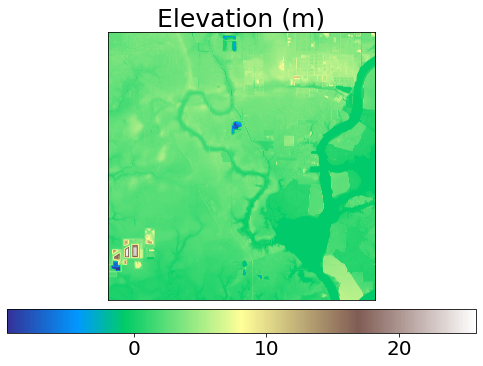

In [41]:
plt.figure(figsize=(14,6))
plt.imshow(dem,cmap=plt.get_cmap('terrain'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',shrink=0.6,pad=0.03)
cb.ax.tick_params(labelsize=20)
plt.title('Elevation (m)',fontsize=25)
plt.show()

In [29]:
tile = cv2.imread(dem_paths[0], cv2.IMREAD_UNCHANGED)

(10012, 10012)

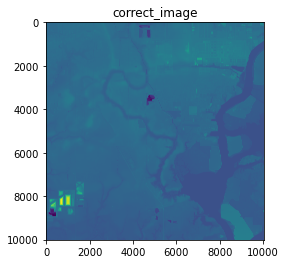

In [36]:
fig, (ax1) = plt.subplots(1,1)
ax1.set_title('correct_image')
ax1.imshow(tile)
plt.show() 